In [38]:
# Import the necessary modules and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the dataset
df = pd.read_csv('train.csv')

# Columns are ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
# Let's see the first few rows of the dataset
print(df.head())

# Let's see the data types of the columns
print(df.dtypes)

# Check missing values
print("Count of missing values:", df.isnull().sum())

# Data distribution
print(df.describe())


         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1   

We can see that mileage is treated as a string, we'd like for it to be a numerical value, let's fix that.

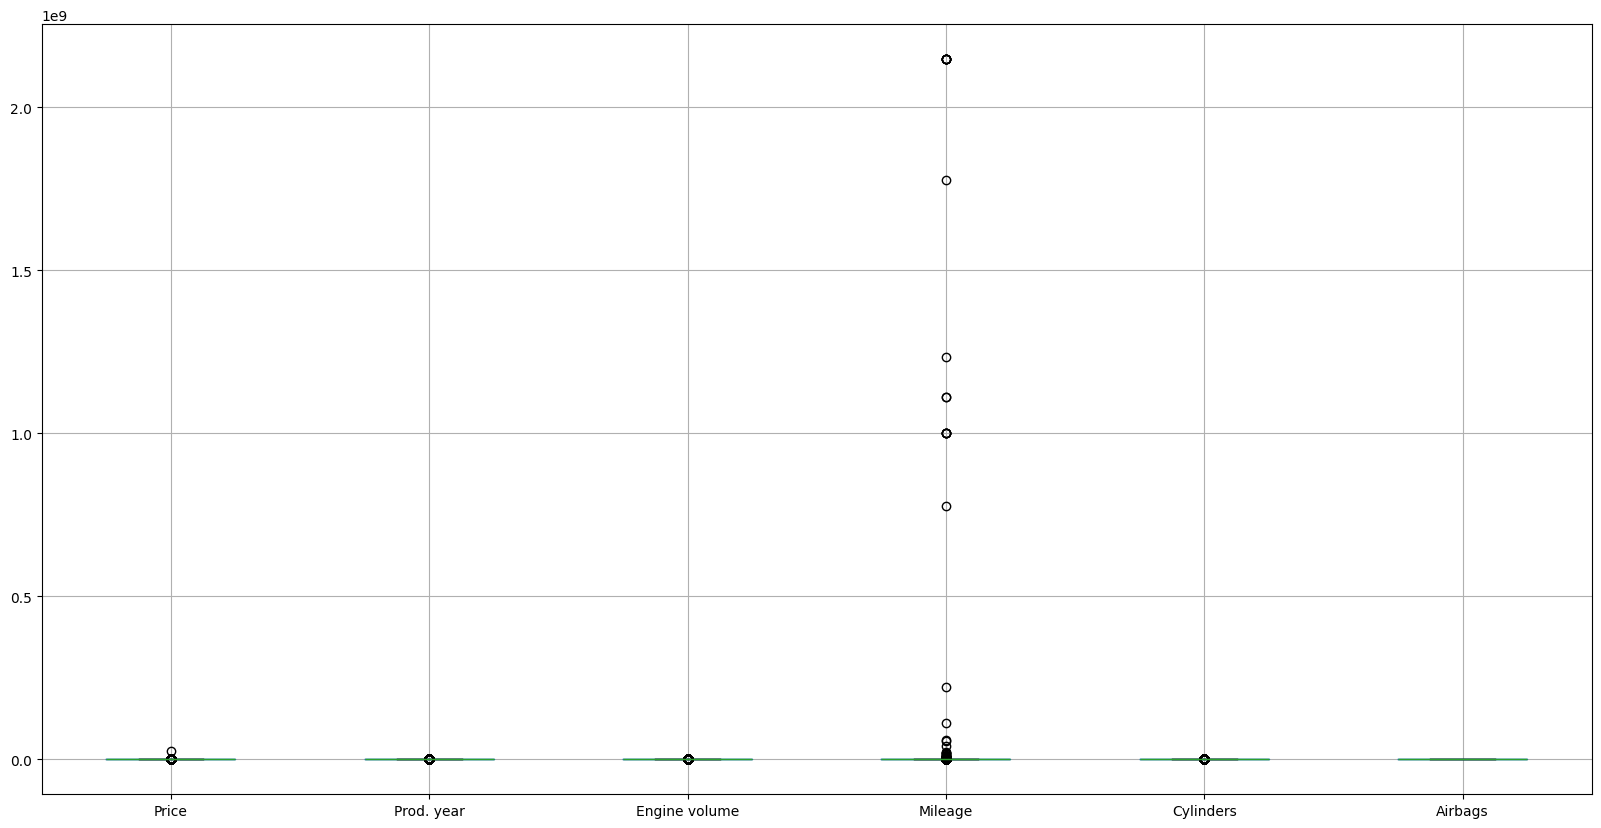

In [39]:
# Convert mileage and engine volume to integer and float respectively by stripping 'km' and converting to integer for mileage and floating first space split for engine volume
df['Mileage'] = df['Mileage'].astype(str)
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(int)

df['Engine volume'] = df['Engine volume'].astype(str)
df['Engine volume'] = df['Engine volume'].str.split(' ').str[0].astype(float)

# Check outliers
# First, let's exclude the ID and Levy columns, as well as doors (treated as a date column)
df = df.drop(['ID'], axis=1)
df = df.drop(['Levy'], axis=1)
df = df.drop(['Doors'], axis=1)

# Let's plot the boxplot for all the columns
plt.figure(figsize=(20, 10))
df.boxplot()
plt.show()

There are no missing values in the dataset. We can observe however that price has a huge outlier. We will clean the data to remove it.

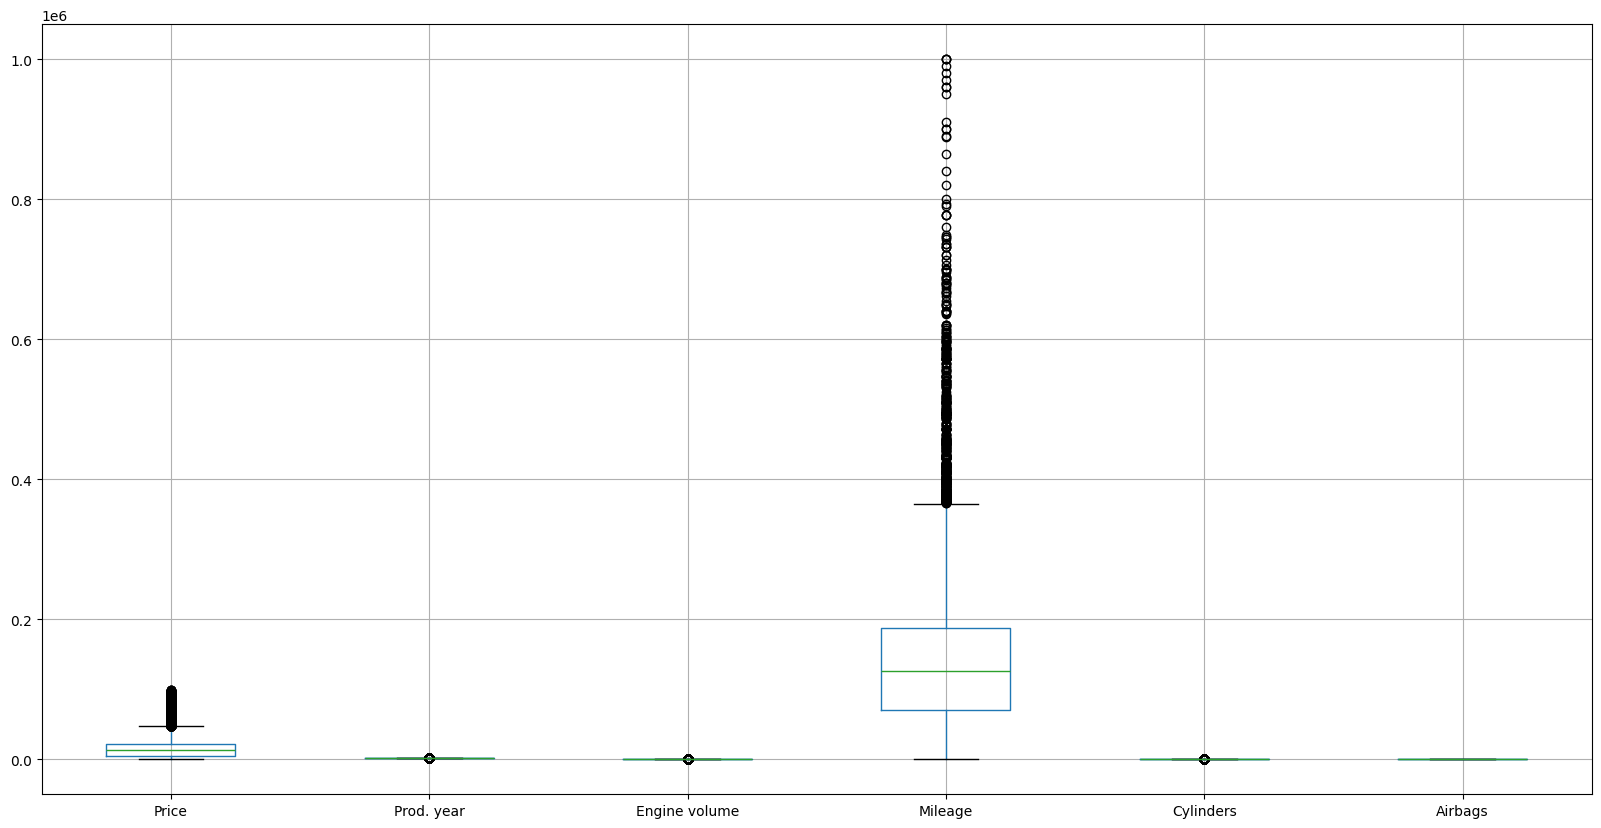

In [40]:
# Remove the largest outliers
df = df[df['Price'] < 100000]
df = df[df['Mileage'] < 1000000]

# Let's plot the boxplot for all the columns again
plt.figure(figsize=(20, 10))
df.boxplot()
plt.show()

Now this looks better, no significant outliers are observed.

The next step is to preprocess our data for training, what we will first do is normalize our data with a Standard Scaler, and then encode categorical labels with one-hot encoding so they can be treated as numerical values, using tf.keras.utils.

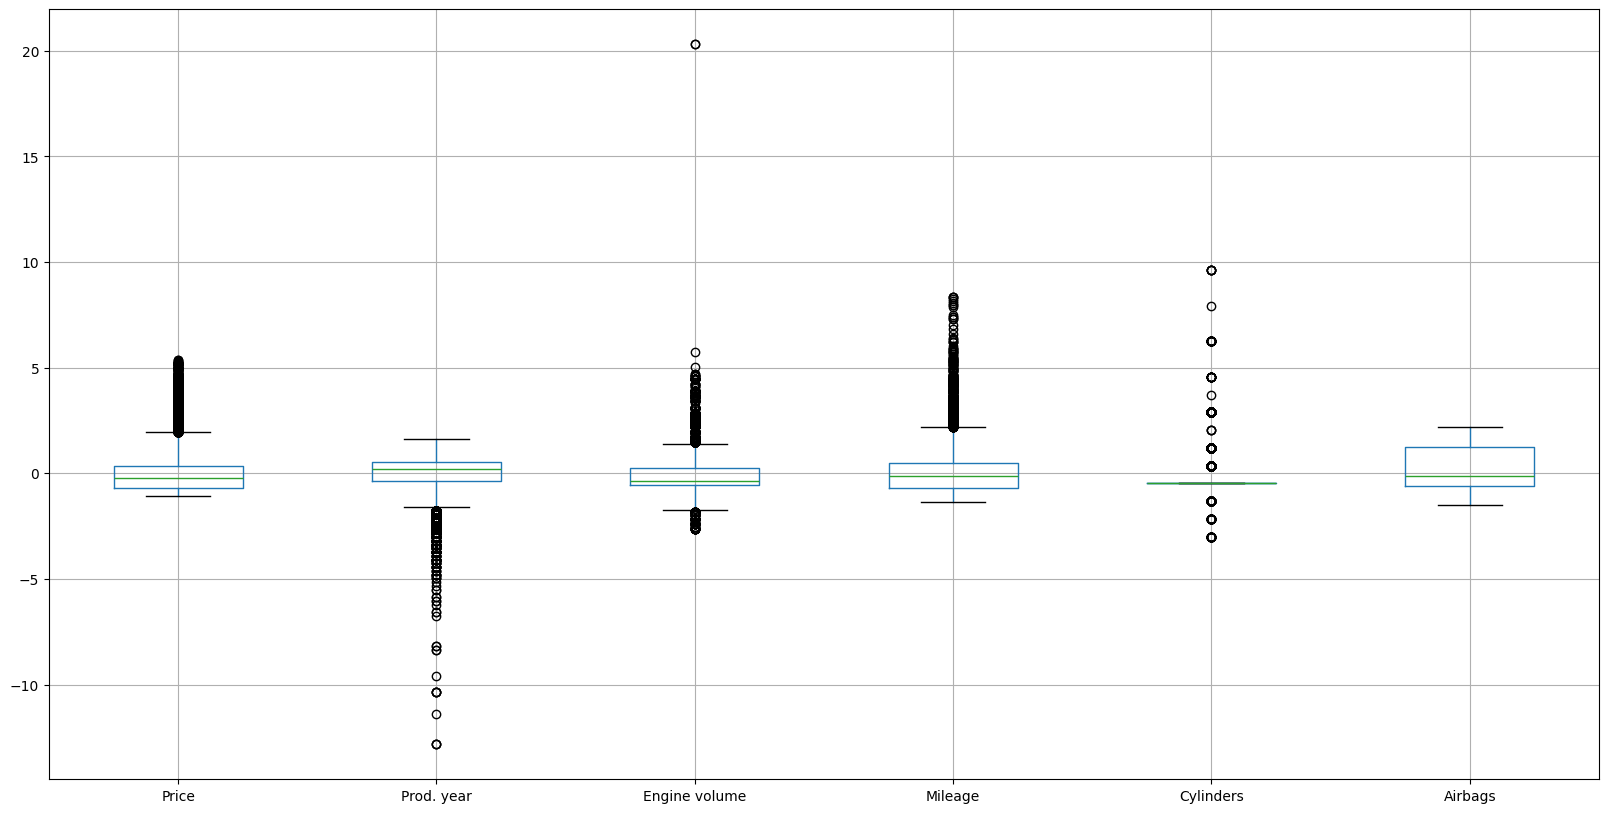

Number of features used for training: 1668


In [41]:
# Standardize the numerical columns
scaler = StandardScaler()
numerical_columns = ['Prod. year', 'Price', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Let's plot the boxplot for all the columns again
plt.figure(figsize=(20, 10))
df.boxplot()
plt.show()

# Convert categorical columns to one-hot encoding
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']
df = pd.get_dummies(df, columns=categorical_columns)

# Split the dataset into training, validation and testing sets
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Number of features used for training:", X_train.shape[1])



After splitting our dataset for the first time, we obtain a number of 1600+ features. We'll need to run a PCA in order to select features to keep and toss those who do not contribute significantly to the model's performance.

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)

print("Number of features after PCA:", X_train.shape[1])

Number of features after PCA: 68


In [46]:
# Print remaining features
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

[0.20633653 0.13919469 0.09250486 0.08336587 0.04141894 0.03522488
 0.03127014 0.02575194 0.02293384 0.02189917 0.02122677 0.01826071
 0.01720153 0.01493259 0.01409485 0.01249978 0.01094925 0.01027948
 0.00872321 0.00805642 0.00736572 0.00662057 0.00637669 0.00541453
 0.00526111 0.00491362 0.00450334 0.00436333 0.00383235 0.00368911
 0.00350191 0.00341907 0.00323607 0.00300514 0.0029458  0.00279611
 0.00269884 0.00258491 0.0023359  0.00218285 0.00205694 0.00200081
 0.0018763  0.00169374 0.00167706 0.00162466 0.00151176 0.00137913
 0.00129506 0.00123877 0.0012237  0.00117488 0.00109124 0.00106702
 0.00104568 0.00101961 0.00095738 0.00094009 0.00091959 0.00090858
 0.00090132 0.00087989 0.00085475 0.00084504 0.00078784 0.00078365
 0.00076141 0.0007591 ]
[162.734317   133.66029609 108.96157031 103.43921807  72.91058432
  67.23816623  63.35136503  57.49049872  54.25370985  53.01574452
  52.19550255  48.41165899  46.9866669   43.77828196  42.53254109
  40.05365917  37.48722002  36.32257032  